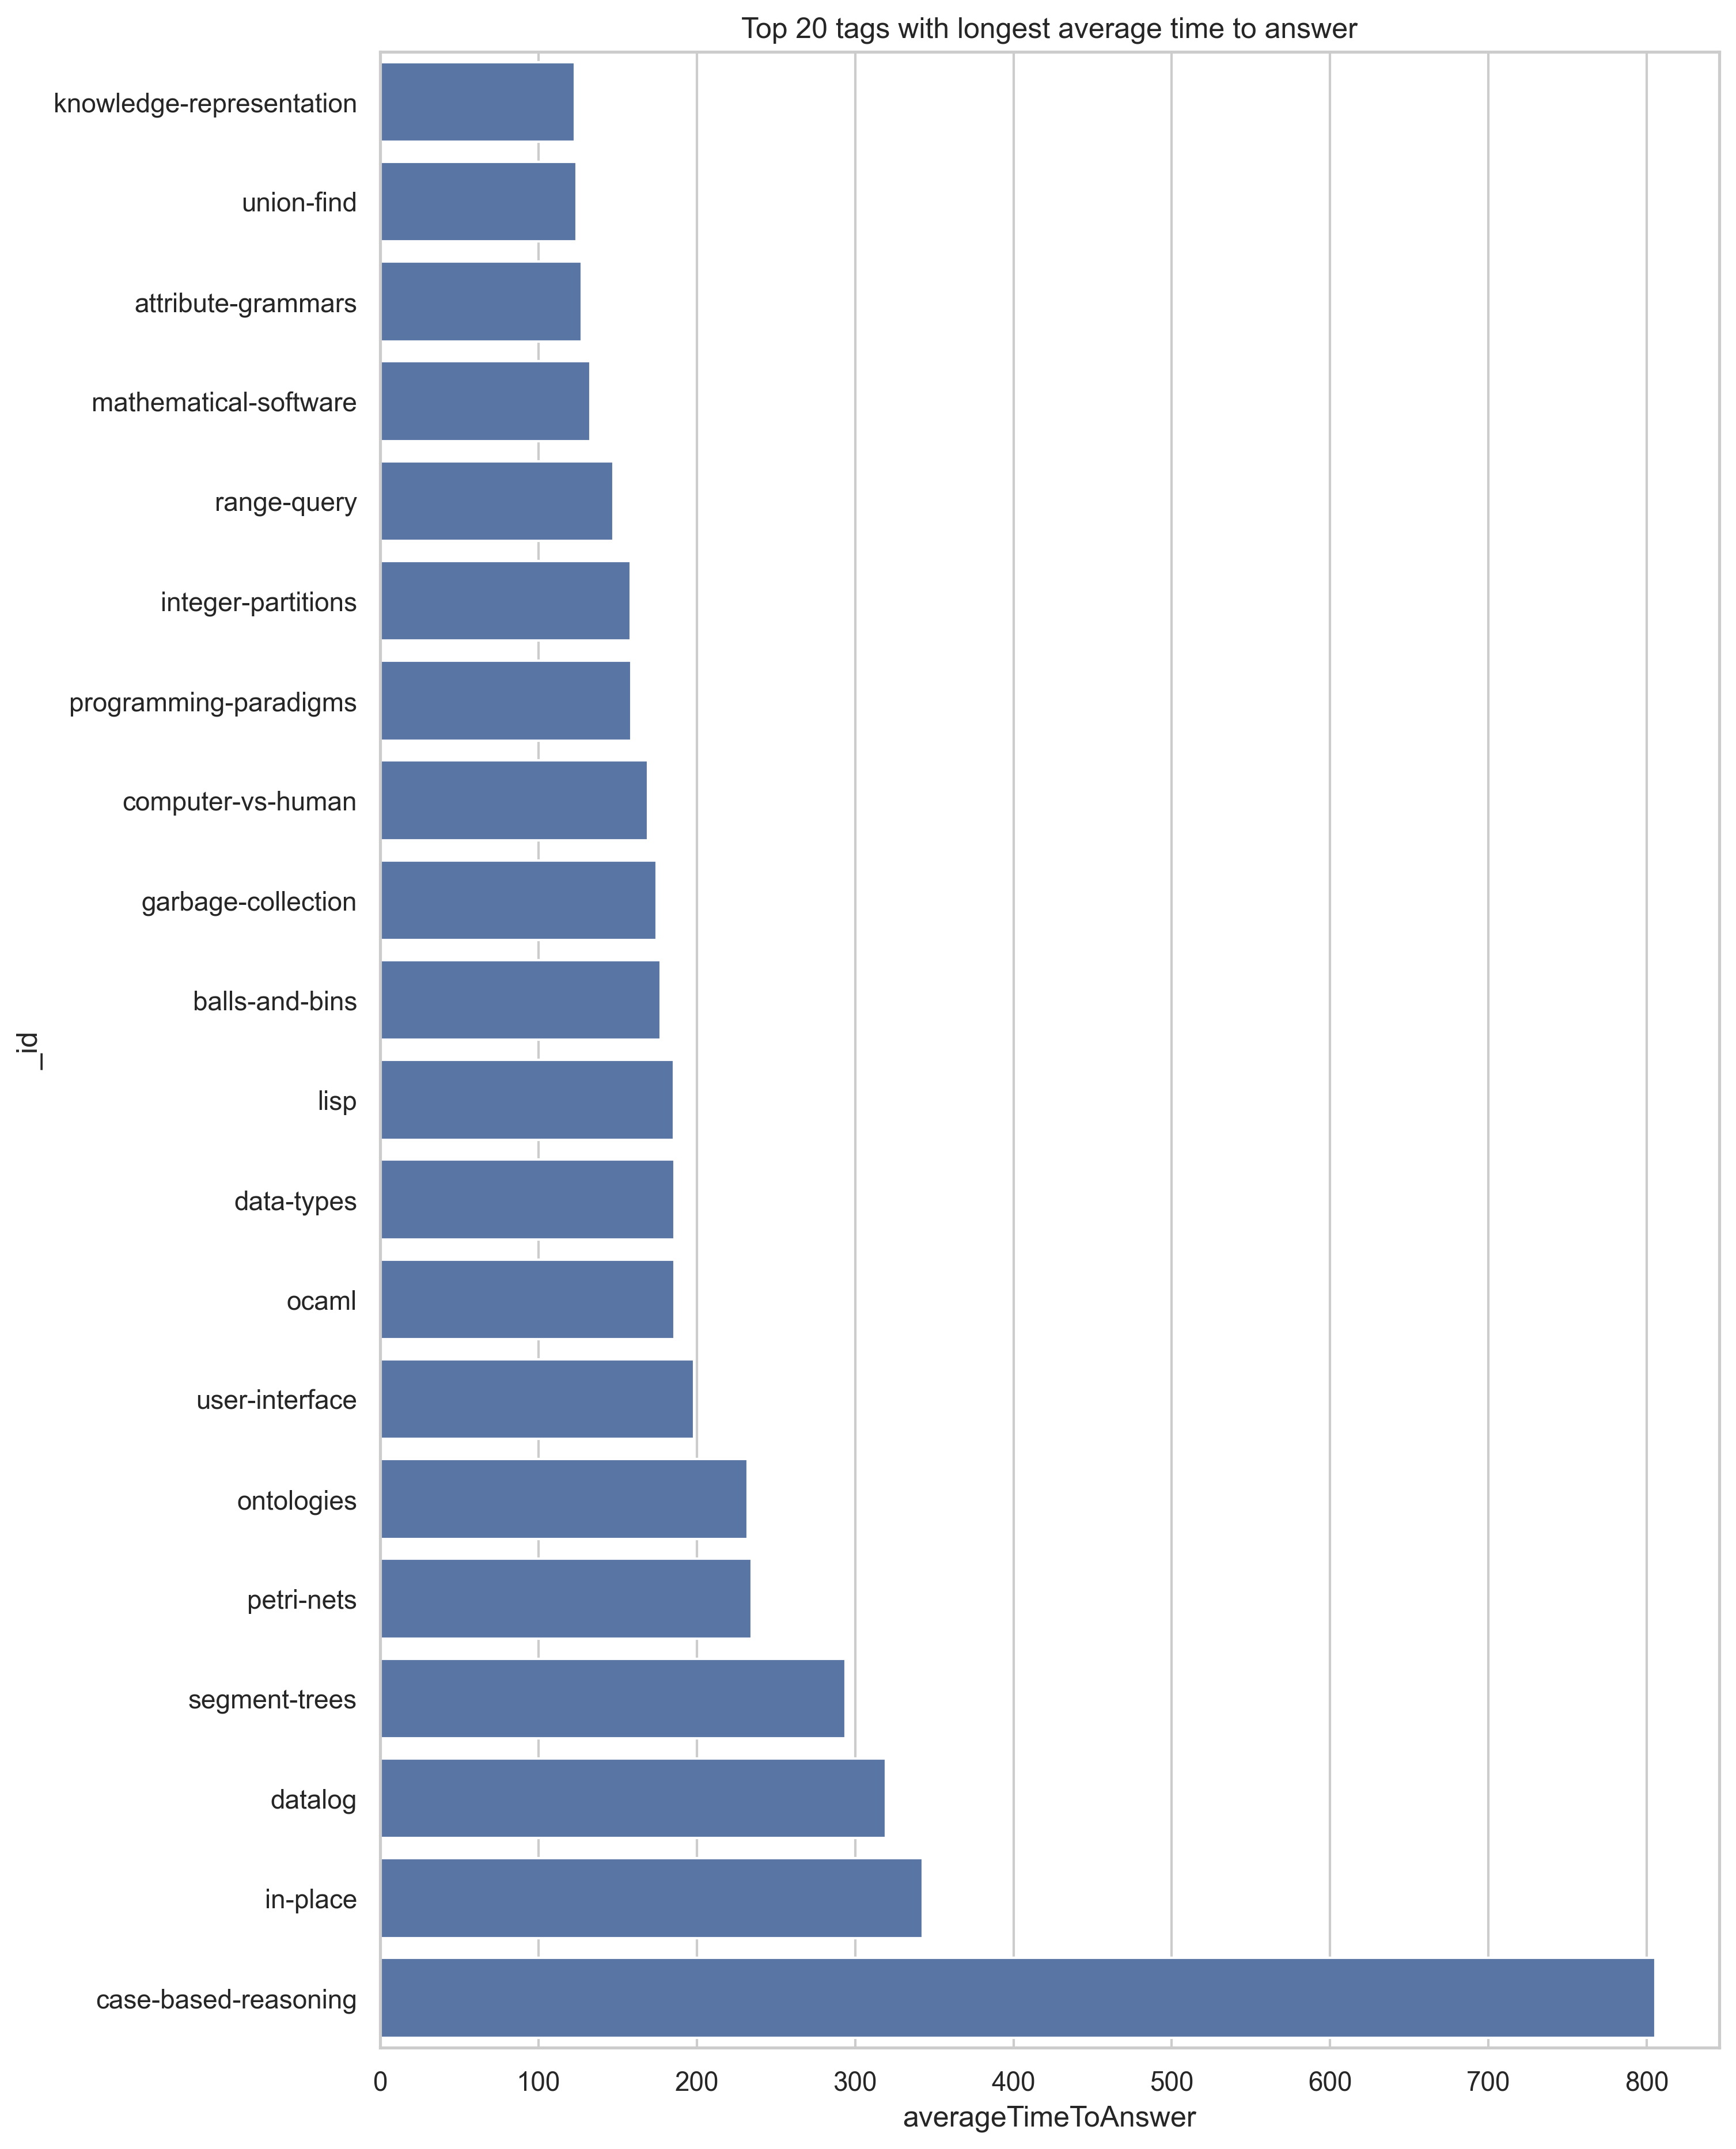

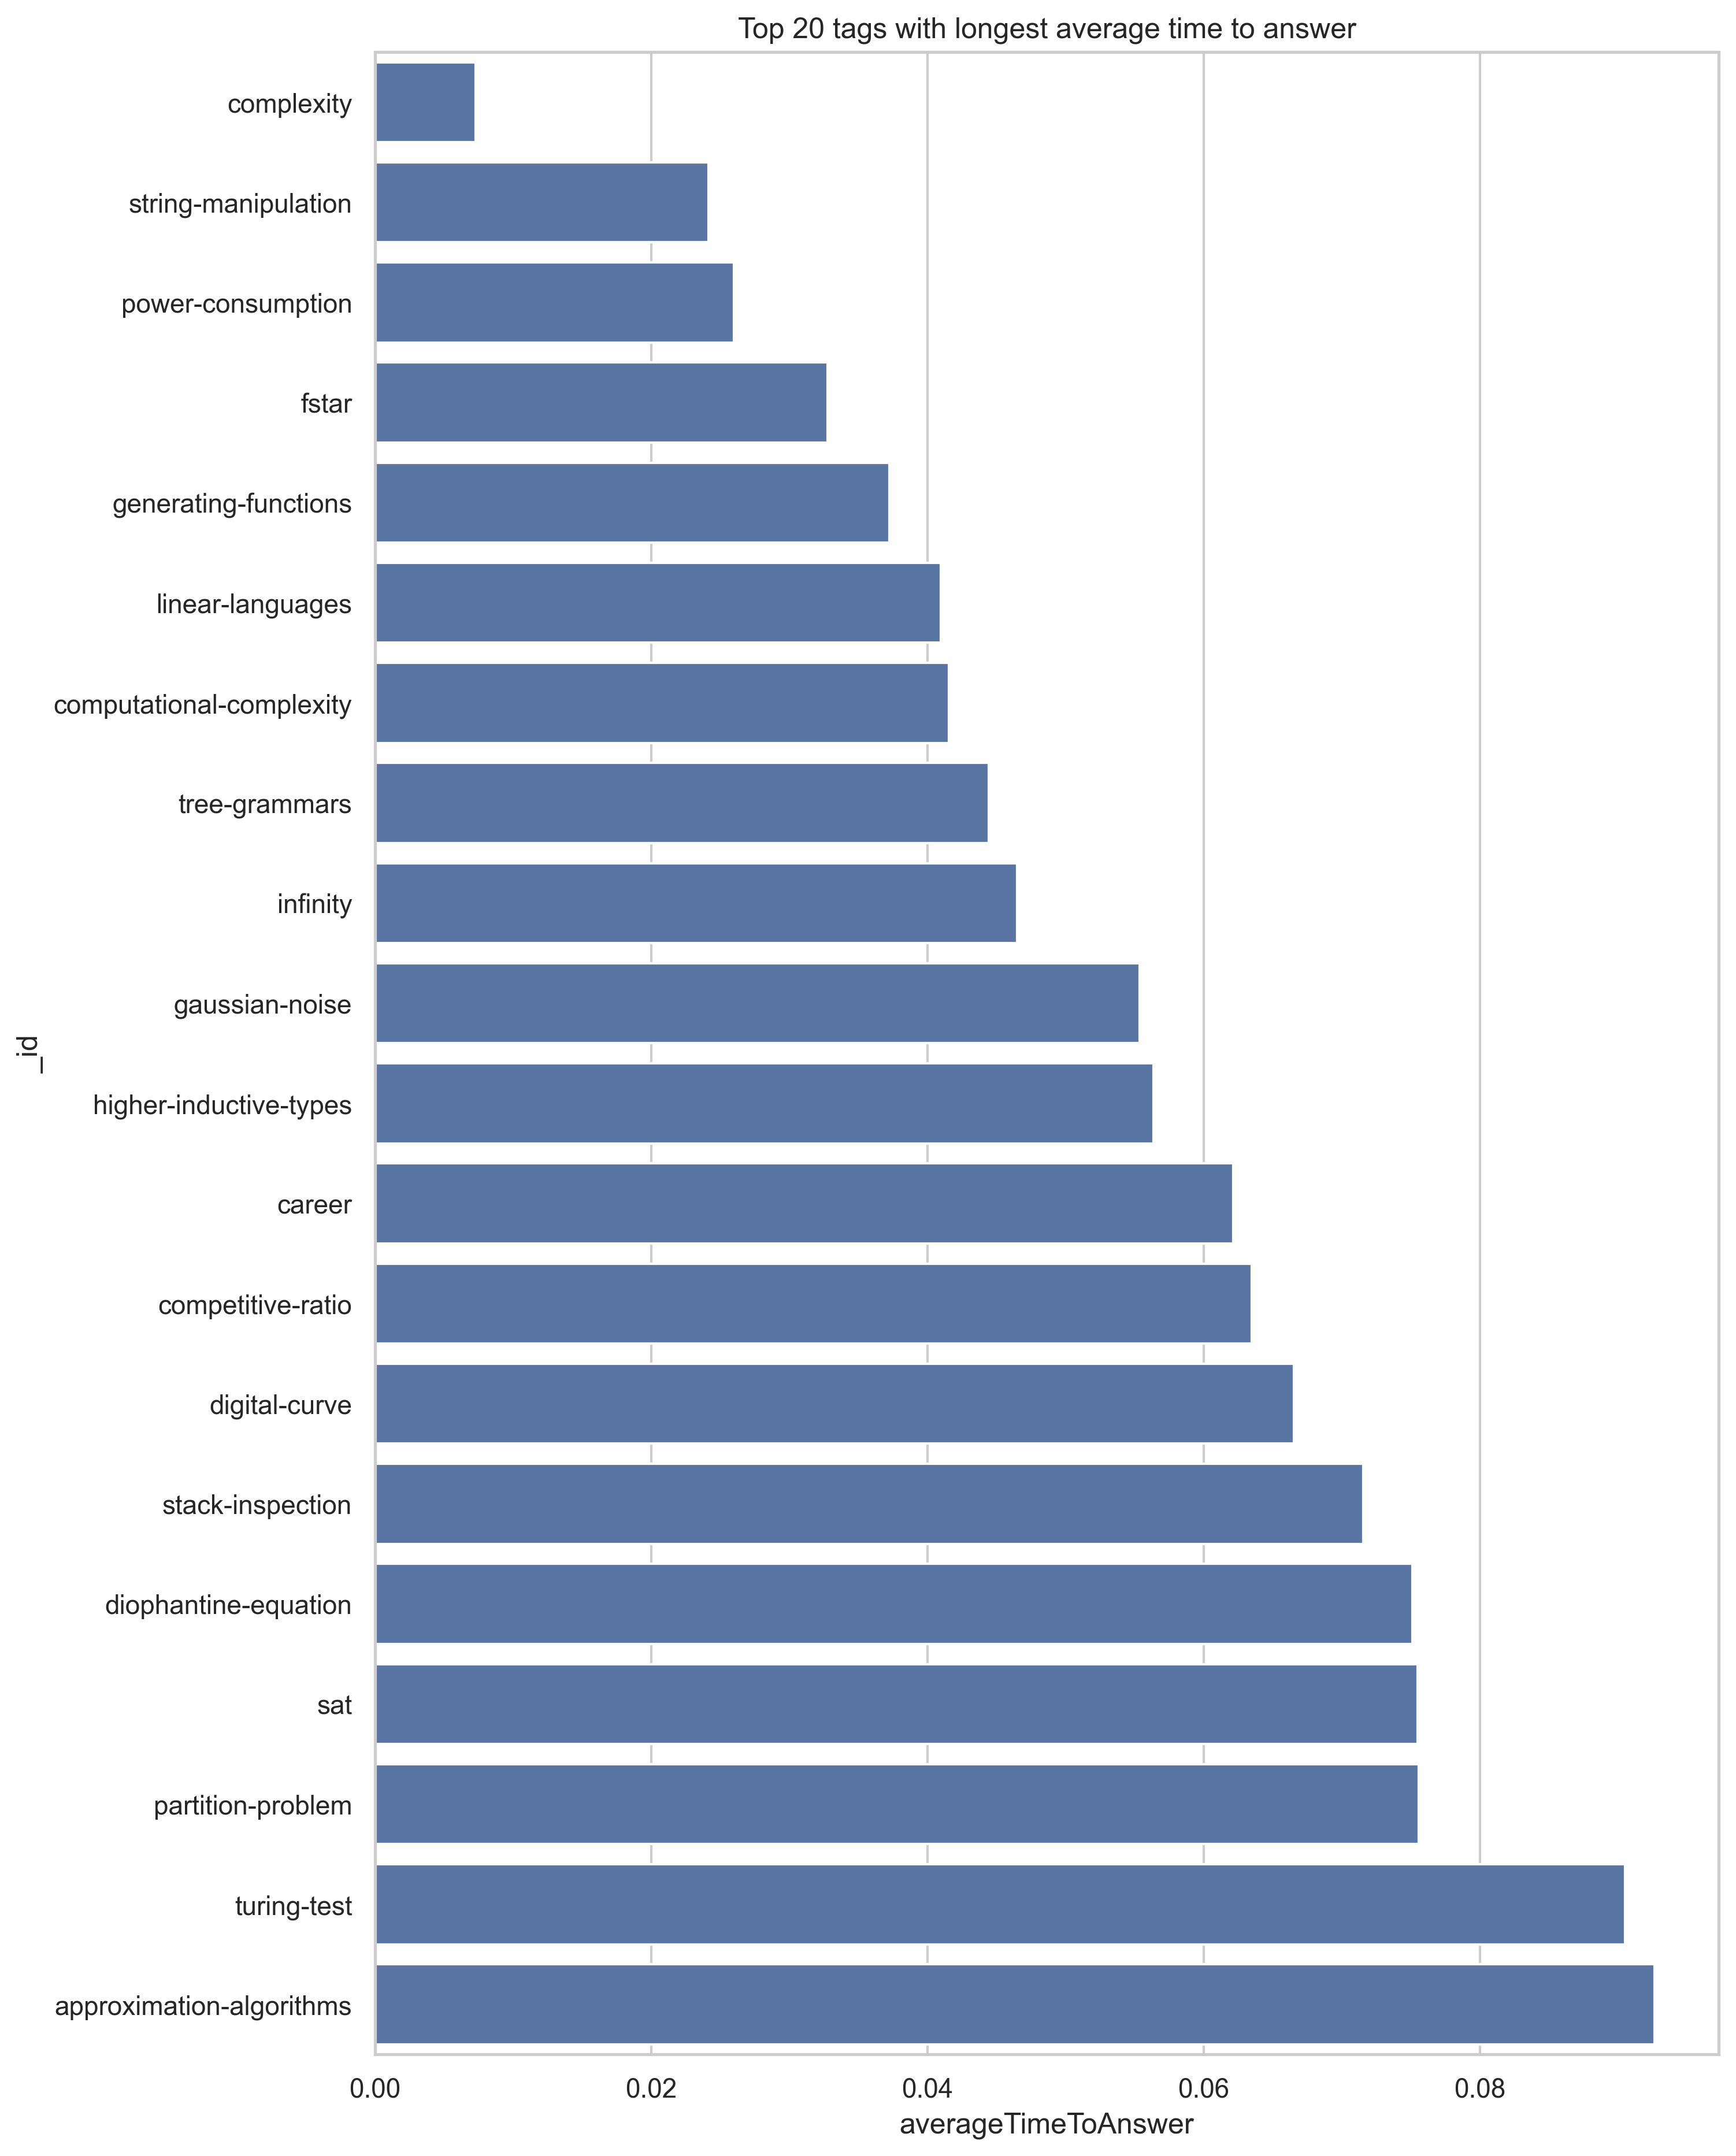

In [18]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

client = MongoClient('mongodb://localhost:27017/')
result = client['stackexchange_cs']['Posts'].aggregate([
    {
        '$match': {
            'PostTypeId': 1, 
            'AcceptedAnswerId': {
                '$ne': None
            }
        }
    }, {
        '$lookup': {
            'from': 'Posts', 
            'localField': 'AcceptedAnswerId', 
            'foreignField': 'PostId', 
            'as': 'acceptedAnswer'
        }
    }, {
        '$unwind': {
            'path': '$acceptedAnswer'
        }
    }, {
        '$unwind': {
            'path': '$Tags'
        }
    }, {
        '$project': {
            'questionDate': '$CreationDate', 
            'answerDate': '$acceptedAnswer.CreationDate', 
            'timeBetween': {
                '$subtract': [
                    '$acceptedAnswer.CreationDate', '$CreationDate'
                ]
            }, 
            'tag': '$Tags'
        }
    }, {
        '$group': {
            '_id': '$tag', 
            'averageTimeToAnswer': {
                '$avg': '$timeBetween'
            }
        }
    }
])

result = list(result)

# top 20 tags and bottom 20 tags
sorted_result = sorted(result, key=lambda x: x['averageTimeToAnswer'])
top_20 = sorted_result[-20:]
bottom_20 = sorted_result[:20]

# plot use seaborn
# top 20
df = pd.DataFrame(top_20)
df['averageTimeToAnswer'] = df['averageTimeToAnswer'].apply(lambda x: x / 3.6e6 / 24)

plt.figure(figsize=(10, 15), dpi=300)  # 修改尺寸以更好地适应横向条形图
sns.barplot(y='_id', x='averageTimeToAnswer', data=df)  # 将条形图转为横向
plt.title('Top 20 tags with longest average time to answer')
plt.show()

# bottom 20
df = pd.DataFrame(bottom_20)
df['averageTimeToAnswer'] = df['averageTimeToAnswer'].apply(lambda x: x / 3.6e6 / 24)

plt.figure(figsize=(10, 15), dpi=300)  # 修改尺寸以更好地适应横向条形图
sns.barplot(y='_id', x='averageTimeToAnswer', data=df)  # 将条形图转为横向
plt.title('Top 20 tags with longest average time to answer')
plt.show()


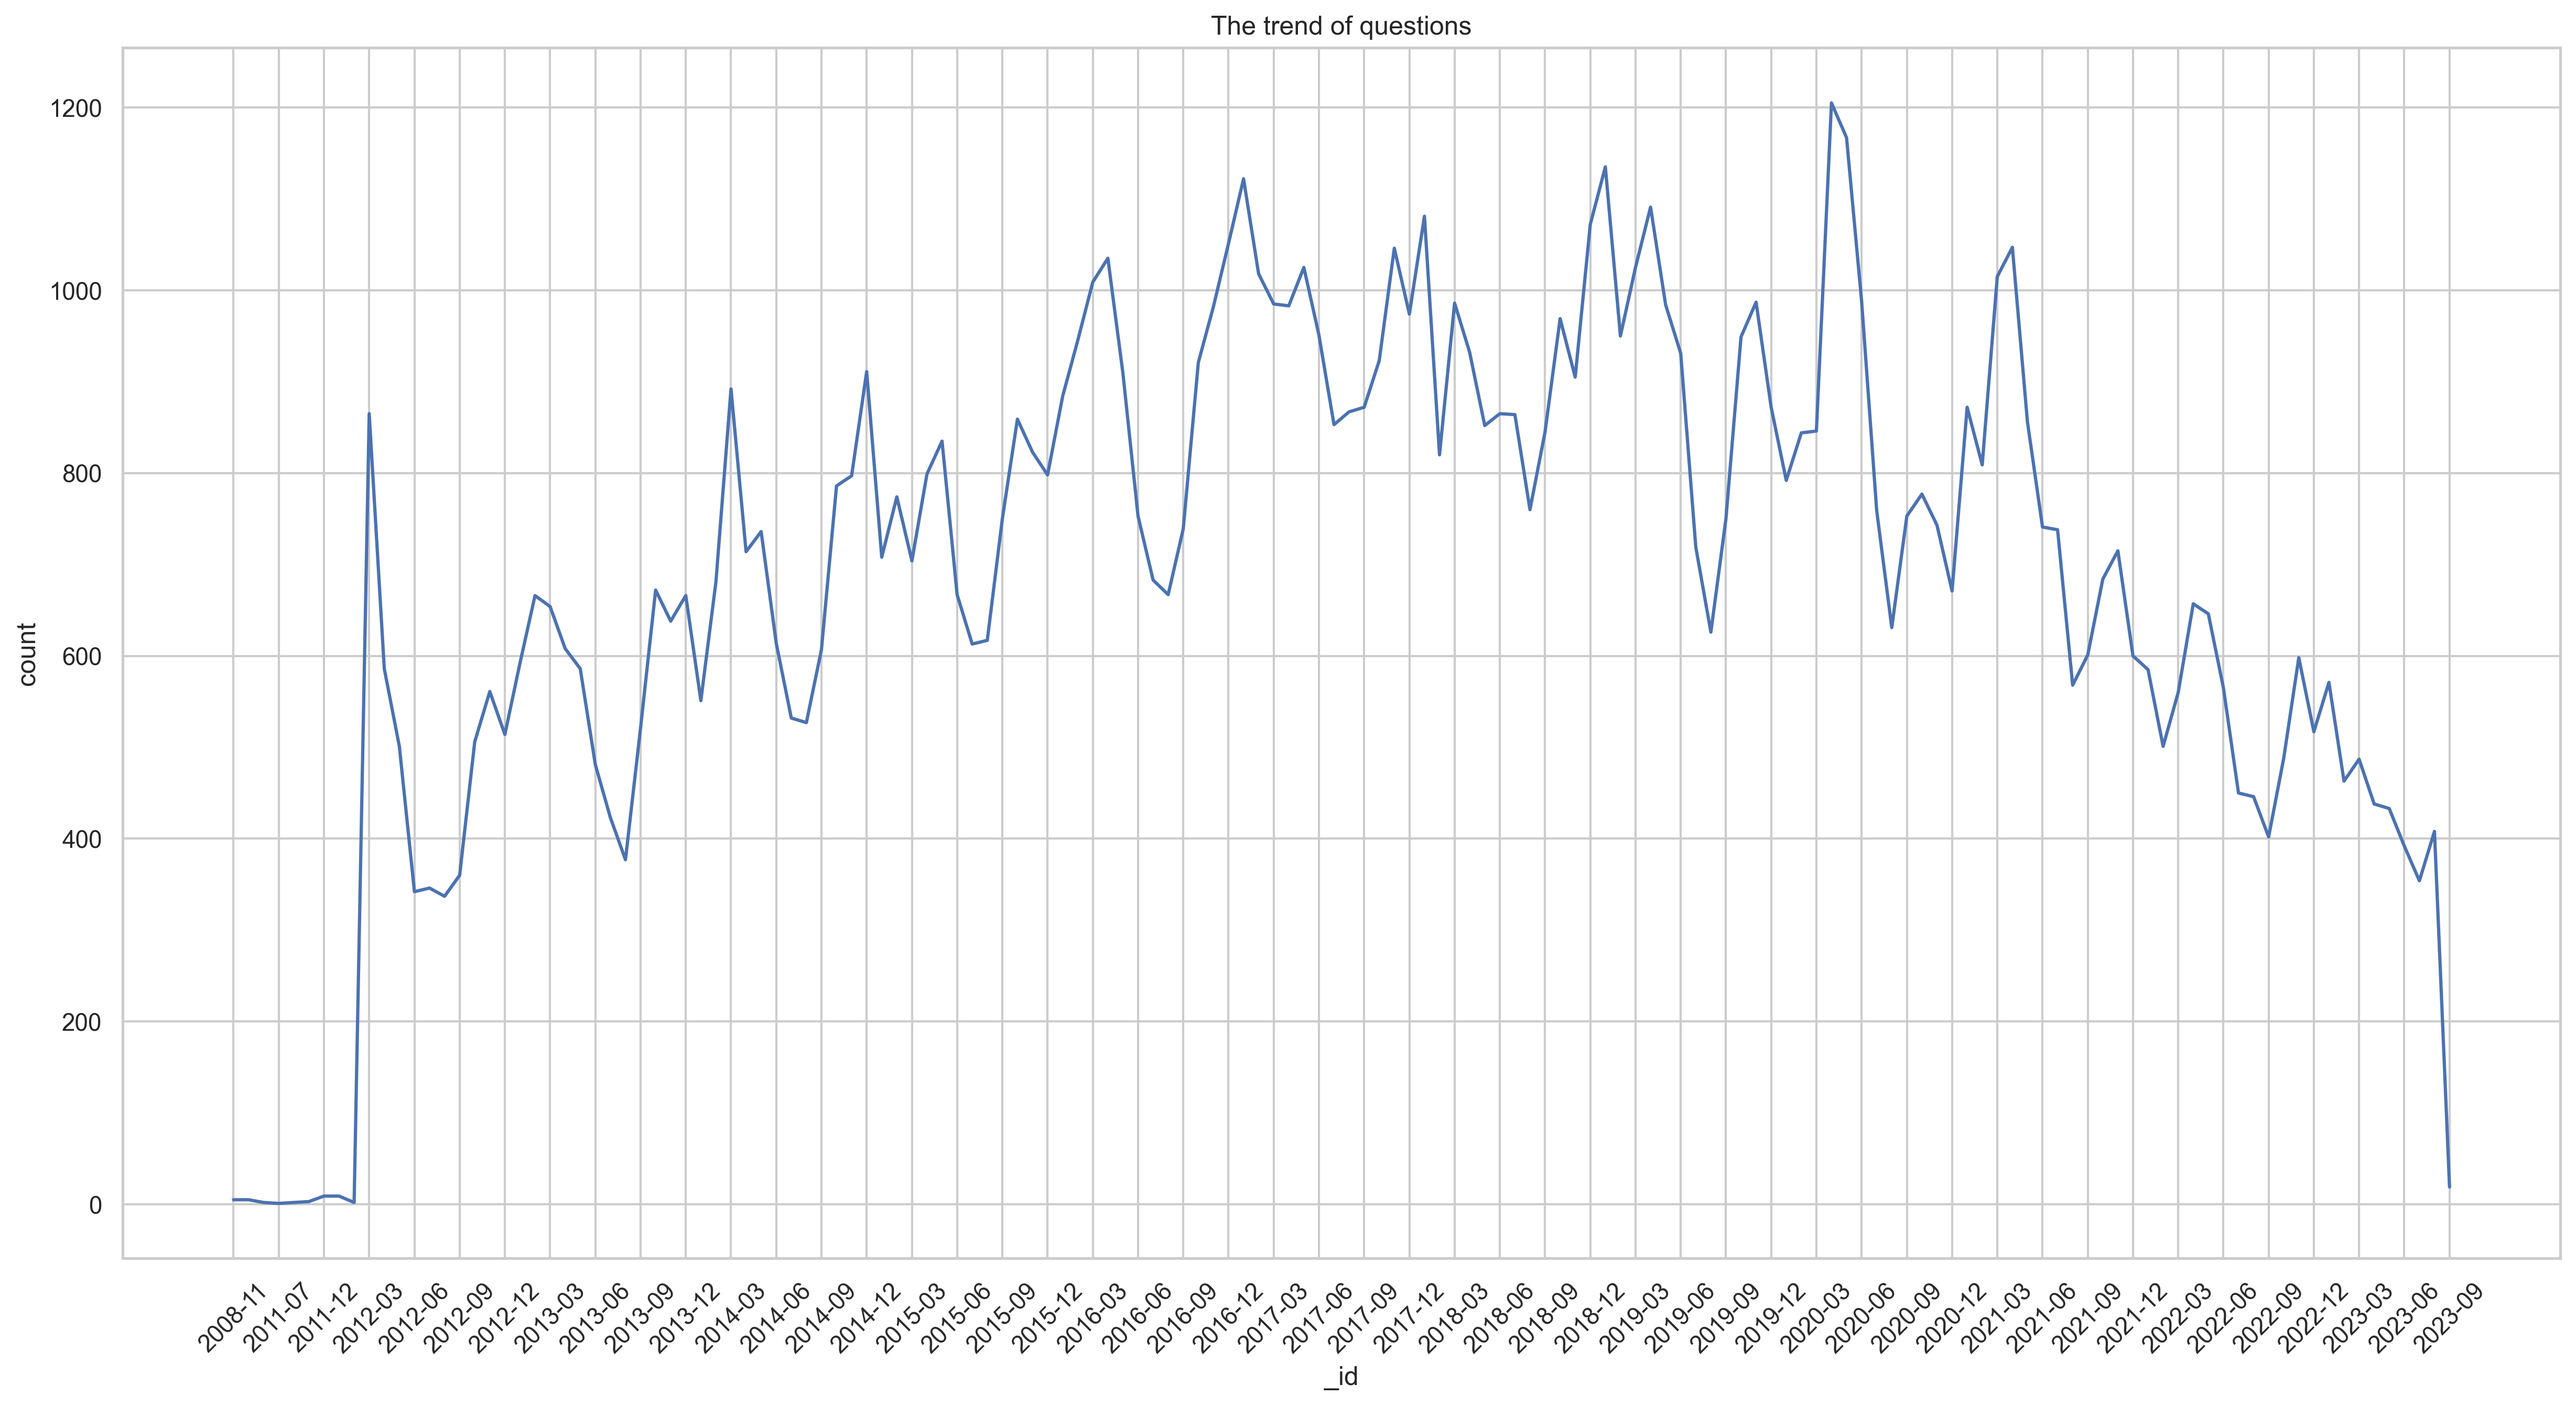

In [30]:
result = client['stackexchange_cs']['Posts'].aggregate([
    {
        '$project': {
            'yearMonth': {
                '$dateToString': {
                    'format': '%Y-%m', 
                    'date': '$CreationDate'
                }
            }
        }
    }, {
        '$group': {
            '_id': '$yearMonth', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }
])

result = list(result)
df = pd.DataFrame(result)

# plot the trend of questions
plt.figure(figsize=(20, 10), dpi=300)
sns.lineplot(x='_id', y='count', data=df)

# skip some xticks to make the xticks more clear
plt.xticks(df.index[::3], df['_id'][::3], rotation=45)

plt.title('The trend of questions')
plt.show()

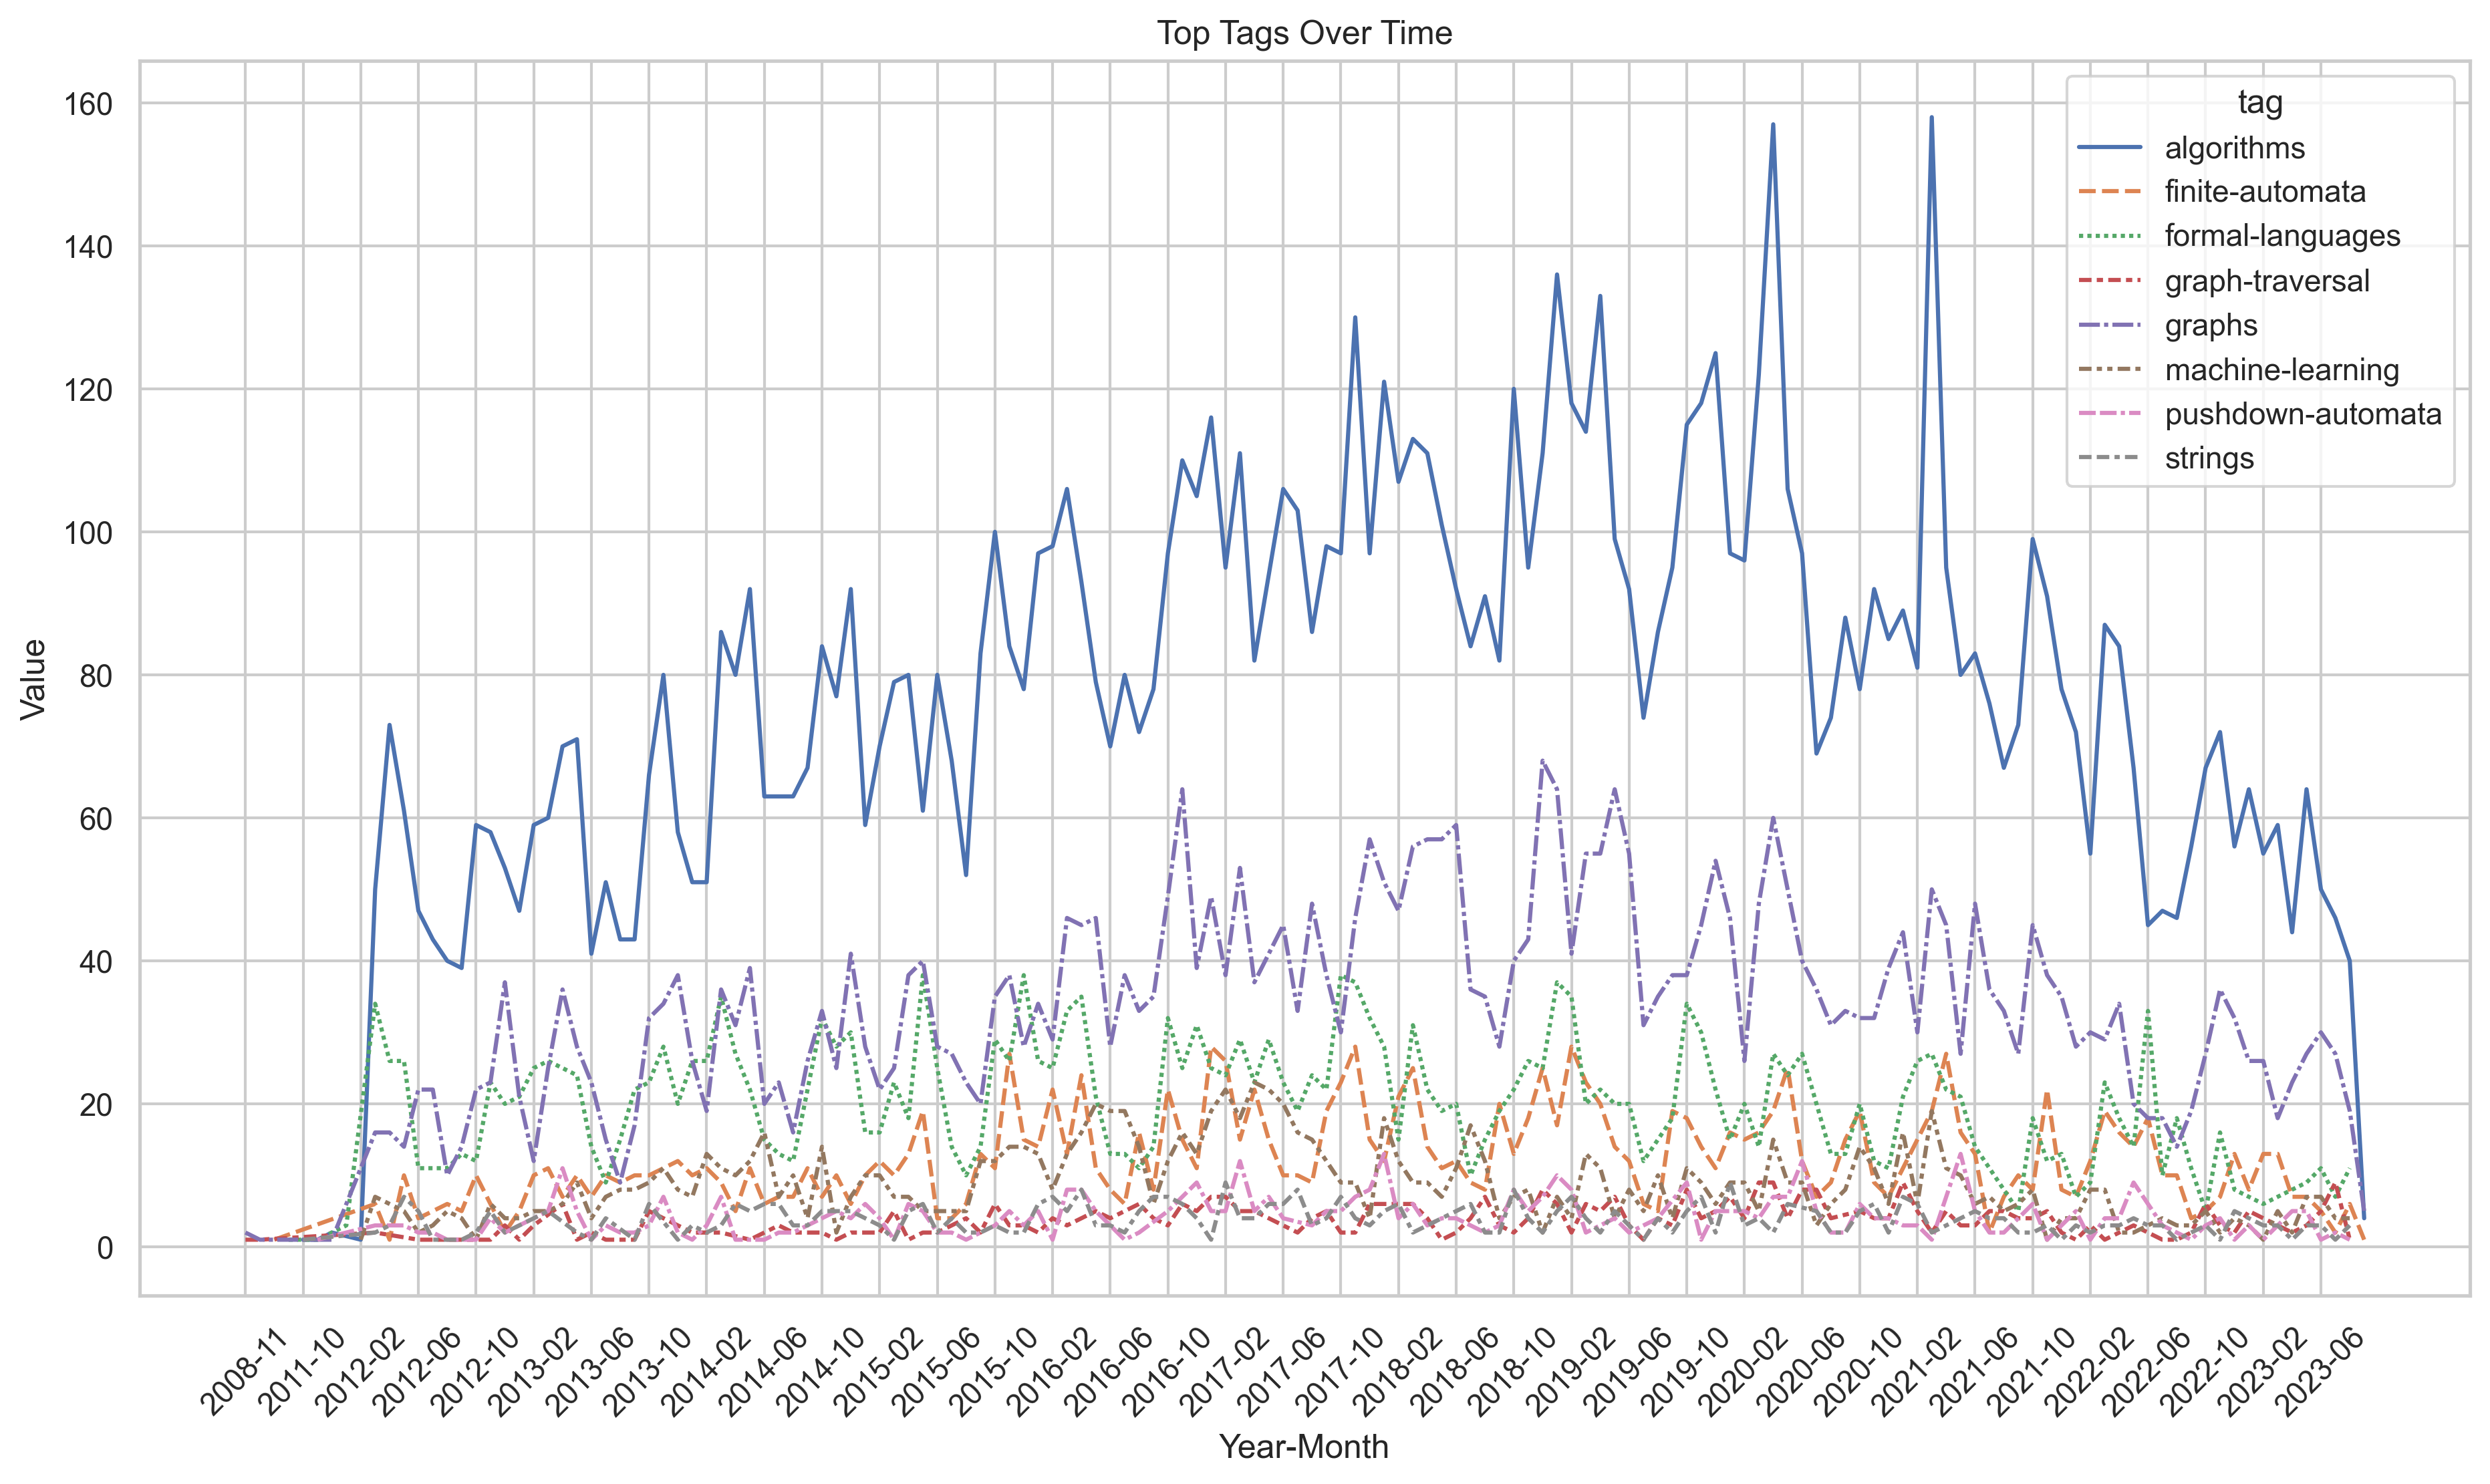

In [39]:
result = client['stackexchange_cs']['Posts'].aggregate([
    {
        '$project': {
            'yearMonth': {
                '$dateToString': {
                    'format': '%Y-%m', 
                    'date': '$CreationDate'
                }
            }, 
            'Tags': 1
        }
    }, {
        '$unwind': '$Tags'
    }, {
        '$group': {
            '_id': {
                'yearMonth': '$yearMonth', 
                'tag': '$Tags'
            }, 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id.yearMonth': 1, 
            'count': -1
        }
    }
])

result = list(result)
df = pd.DataFrame(result)

df['yearMonth'] = df['_id'].apply(lambda x: x['yearMonth'])
df['tag'] = df['_id'].apply(lambda x: x['tag'])

top_tags_each_month = df.groupby('yearMonth').apply(lambda x: x.nlargest(1, 'count')['tag']).reset_index(level=0, drop=True)
filtered_df = df[df['tag'].isin(top_tags_each_month)]

pivot_df = filtered_df.pivot(index='tag', columns='yearMonth', values='count')

plt.figure(figsize=(15, 8), dpi=300)
sns.lineplot(data=pivot_df.T)
# drop some xticks to make the xticks more clear
plt.xticks(pivot_df.columns[::4], pivot_df.columns[::4], rotation=45)
plt.title('Top Tags Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Value')
plt.show()
